In [170]:
import pandas as pd 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from rfpimp import permutation_importances
from sklearn.metrics import r2_score

headers = ["Дата", "Глубина манометра", "Dшт", "Руст (ср)", "Рзаб (ср)", "Pлин (ср)", "Руст", "Рзаб", "Рлин", "Туст", "Тна шлейфе", "Тзаб", "Tлин", "Дебит газа", "Дебит ст. конд.", "Дебит воды", "Дебит смеси", "Дебит гааз", "Дебит кон нестабильный", "Дебит воды", "Нэф", "Рпл. Тек (послед точка на КВД)", "Рпл. Тек (Расчет по КВД)", "Рпл. Тек (Карноухов)", "Pсб", "Pсб", "Ro_g", "Ro_c", "Ro_w", "Удельная плотность газа", "G_total", "КГФ", "КГФ_1"]
# df = pd.read_excel('ID_data_mass_18122012.xlsx', sheet_name='VU', header=1)
df = pd.read_excel('ID_data_mass_18122012.xlsx', index_col= 0, sheet_name='VU', skiprows=2)
df.columns = headers
df['КГФ_1'] = df['КГФ_1'].apply(lambda x: x*1000)
df['КГФ'] = df['КГФ'].mask(df['КГФ'].isna(), df['КГФ_1'])
del df['КГФ_1']
del df['Дата']
df.dropna(axis = 0, subset = ['G_total','КГФ'], how = 'all', inplace = True)
df = df.replace(['-','не спускался'], np.nan)
# df.dropna(thresh=55 ,axis=1)

# df = df.drop(0)
# df = df.drop(df.columns[0:2], axis=1)
# df = df.dropna(subset=["G_total", "КГФ"], how='all')
# df = df.replace(['-','не спускался'], np.nan)
# df["KGF"] = df["КГФ"] + df["КГФ.1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 804 to 22503
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Глубина манометра               90 non-null     float64
 1   Dшт                             93 non-null     float64
 2   Руст (ср)                       93 non-null     float64
 3   Рзаб (ср)                       90 non-null     float64
 4   Pлин (ср)                       93 non-null     float64
 5   Руст                            93 non-null     float64
 6   Рзаб                            90 non-null     float64
 7   Рлин                            93 non-null     float64
 8   Туст                            93 non-null     float64
 9   Тна шлейфе                      60 non-null     float64
 10  Тзаб                            90 non-null     float64
 11  Tлин                            93 non-null     float64
 12  Дебит газа                      9

C:\Users\whr1t\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [171]:
df.describe()

,Глубина манометра,Dшт,Руст (ср),Рзаб (ср),Pлин (ср),Руст,Рзаб,Рлин,Туст,Тна шлейфе,...,Рпл. Тек (Расчет по КВД),Рпл. Тек (Карноухов),Pсб,Pсб,Ro_g,Ro_c,Ro_w,Удельная плотность газа,G_total,КГФ
count,90.000000,93.000000,93.000000,90.000000,93.000000,93.000000,90.000000,93.000000,93.000000,60.000000,...,81.000000,64.000000,93.000000,93.000000,23.000000,93.000000,23.0,93.000000,23.000000,93.000000
mean,3524.086667,10.951183,228.293412,331.762255,99.860962,227.644269,330.334444,98.005453,56.172043,43.091667,...,50.943684,50.773437,95.162366,93.917953,0.807631,780.847527,1000.0,0.665260,5.742359,201.705968
std,144.474862,2.423172,41.897238,56.481235,7.300663,41.757127,56.357493,12.425851,11.250781,19.602337,...,4.378416,4.006591,5.136060,5.068897,0.015076,62.795111,0.0,0.020485,2.112717,49.253925
min,3276.000000,6.350000,138.157895,174.000000,73.306638,136.000000,174.000000,40.739839,24.200000,14.000000,...,39.900000,41.600000,85.500000,84.381939,0.787416,186.000000,1000.0,0.570000,2.782623,131.000000
25%,3427.625000,9.530000,201.636750,297.797500,95.945951,200.000000,294.625000,95.335032,50.300000,33.300000,...,48.300000,49.425000,90.700000,89.513940,0.787416,782.000000,1000.0,0.660000,4.381813,164.000000
50%,3579.000000,11.110000,229.894737,337.789172,100.800000,228.000000,334.250000,100.260000,58.000000,38.700000,...,50.800000,50.900000,94.200000,92.968172,0.806017,787.000000,1000.0,0.667000,5.250915,192.000000
75%,3652.250000,12.700000,252.000000,364.150000,103.865199,252.000000,362.150000,104.000000,64.000000,46.375000,...,55.400000,52.700000,99.800000,98.494942,0.821344,793.700000,1000.0,0.679000,6.125723,224.000000
max,3670.000000,15.880000,337.108108,458.600000,121.682930,333.000000,458.500000,123.616800,75.000000,110.200000,...,56.700000,56.800000,104.000000,102.640020,0.824330,801.000000,1000.0,0.684660,10.931155,385.415949


In [172]:
df=df.drop(['Ro_g', 'Ro_w'], axis=1)
# del df['Ro_g', 'Ro_w']

In [173]:
# tr = df.iloc[:,1:31]
tr = df.copy()
tr = tr.replace(np.nan, -100)
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 804 to 22503
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Глубина манометра               93 non-null     float64
 1   Dшт                             93 non-null     float64
 2   Руст (ср)                       93 non-null     float64
 3   Рзаб (ср)                       93 non-null     float64
 4   Pлин (ср)                       93 non-null     float64
 5   Руст                            93 non-null     float64
 6   Рзаб                            93 non-null     float64
 7   Рлин                            93 non-null     float64
 8   Туст                            93 non-null     float64
 9   Тна шлейфе                      93 non-null     float64
 10  Тзаб                            93 non-null     float64
 11  Tлин                            93 non-null     float64
 12  Дебит газа                      9

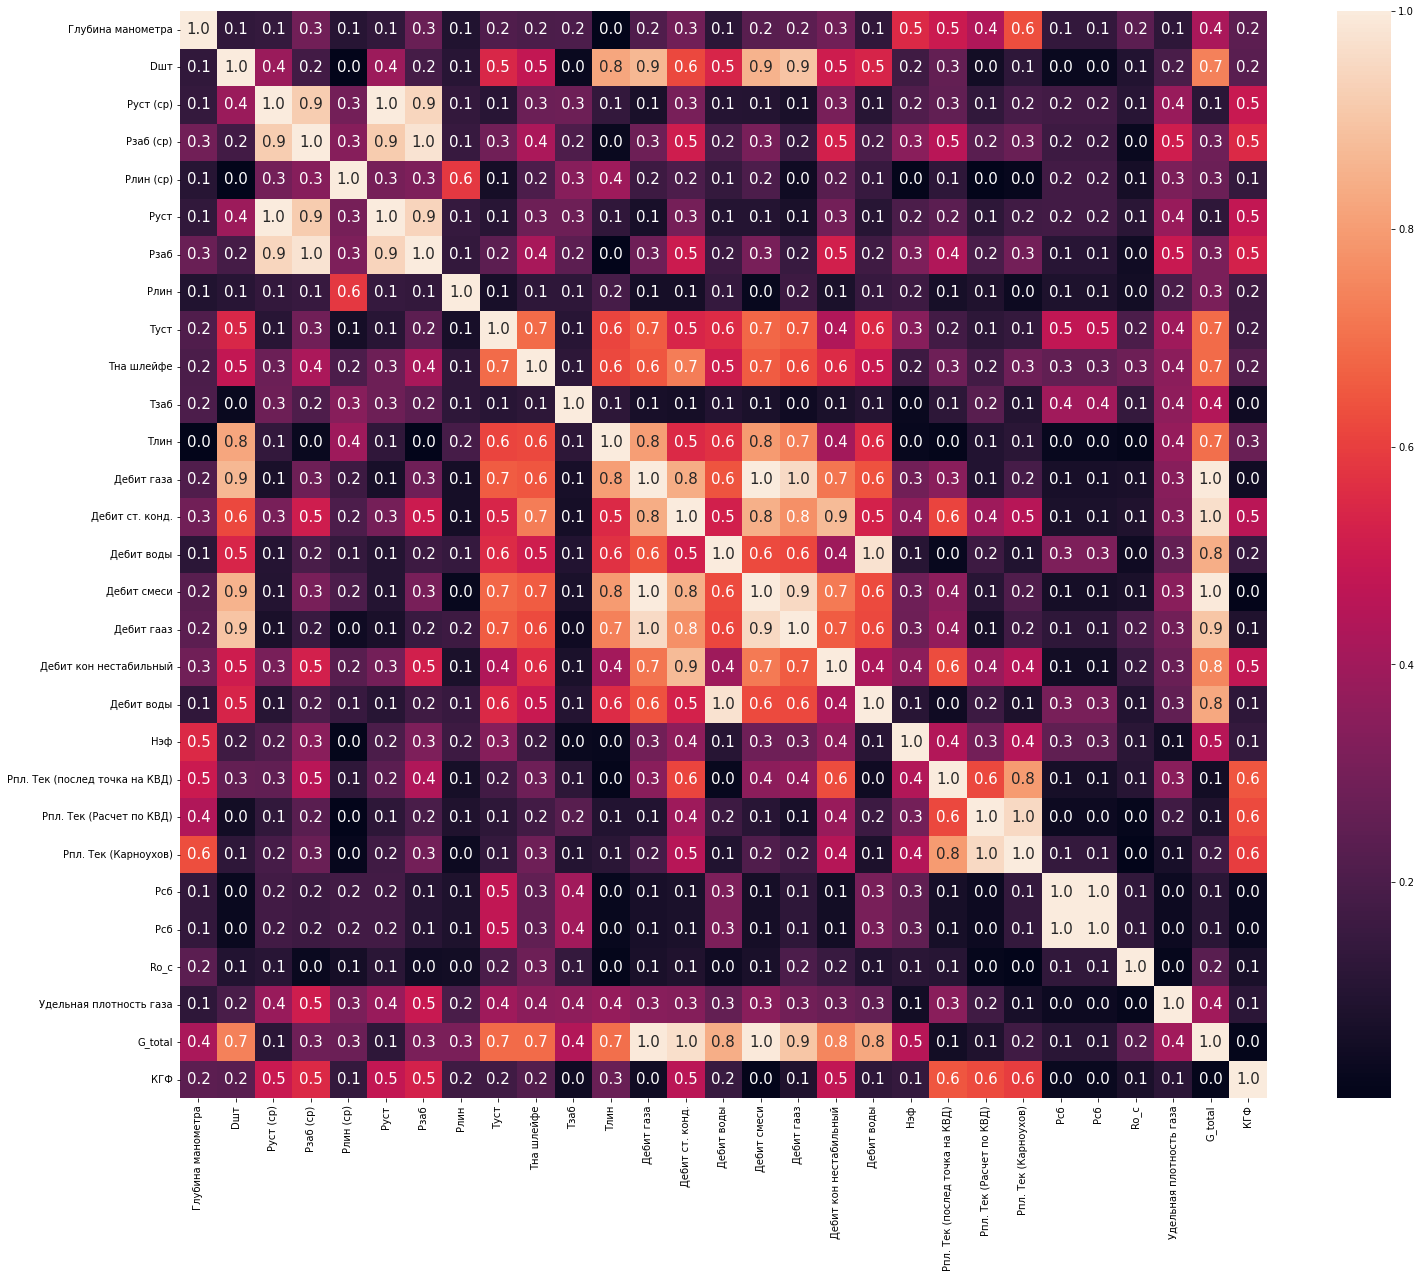

In [174]:
plt.subplots(figsize=(25, 20))
corrMatrix = df.corr()
sn.heatmap(abs(corrMatrix), annot=True, cbar=True, annot_kws={'size':15},  square=True, fmt=".1f")
plt.show()

       Глубина манометра    Dшт   Руст (ср)  Рзаб (ср)   Pлин (ср)   Руст  \
№                                                                           
804               3576.3   7.94  249.600000      370.1  101.800000  249.0   
804               3576.3   9.53  233.500000      364.6  101.300000  231.0   
804               3576.3  11.11  213.400000      357.1  101.600000  211.0   
804               3576.3  12.70  191.600000      347.4   98.400000  187.0   
804               3576.3  14.29  171.900000      337.7   99.200000  169.0   
...                  ...    ...         ...        ...         ...    ...   
22503             3284.0  12.70  215.000000      307.8   98.600000  215.0   
22503             3284.0  14.29  198.000000      293.6   98.500000  197.0   
22503             3288.6   7.94  231.229167      309.1   92.600000  230.0   
22503             3288.6  11.11  217.201681      293.9   93.100000  215.0   
22503             3289.8   9.53  199.000000      271.0   95.945951  199.0   

<BarContainer object of 26 artists>

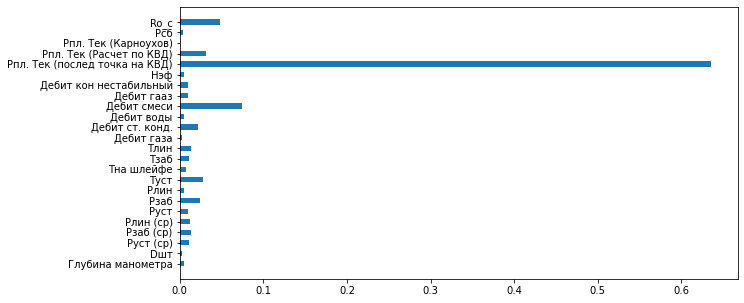

In [178]:
X_train = tr.iloc[:, 0:26]
y_train = tr.iloc[:, 27:29]
print(X_train)
print(y_train)
rf = RandomForestRegressor(max_depth=20, random_state=0)
rf.fit(X_train, y_train)
plt.figure(figsize=(10,5))
plt.barh(X_train.columns, rf.feature_importances_, 0.5, align="center")

In [176]:
tr.columns

Index(['Глубина манометра', 'Dшт', 'Руст (ср)', 'Рзаб (ср)', 'Pлин (ср)',
       'Руст', 'Рзаб', 'Рлин', 'Туст', 'Тна шлейфе', 'Тзаб', 'Tлин',
       'Дебит газа', 'Дебит ст. конд.', 'Дебит воды', 'Дебит смеси',
       'Дебит гааз', 'Дебит кон нестабильный', 'Дебит воды', 'Нэф',
       'Рпл. Тек (послед точка на КВД)', 'Рпл. Тек (Расчет по КВД)',
       'Рпл. Тек (Карноухов)', 'Pсб', 'Pсб', 'Ro_c', 'Удельная плотность газа',
       'G_total', 'КГФ'],
      dtype='object')

№
804      249.0
804      231.0
804      211.0
804      187.0
804      169.0
         ...  
22503    215.0
22503    197.0
22503    230.0
22503    215.0
22503    199.0
Name: Руст, Length: 93, dtype: float64
Index(['Глубина манометра', 'Dшт', 'Руст (ср)', 'Рзаб (ср)'], dtype='object')
№
804      3576.3
804      3576.3
804      3576.3
804      3576.3
804      3576.3
          ...  
22503    3284.0
22503    3284.0
22503    3288.6
22503    3288.6
22503    3289.8
Name: Глубина манометра, Length: 93, dtype: float64
№
804       7.94
804       9.53
804      11.11
804      12.70
804      14.29
         ...  
22503    12.70
22503    14.29
22503     7.94
22503    11.11
22503     9.53
Name: Dшт, Length: 93, dtype: float64
№
804      249.600000
804      233.500000
804      213.400000
804      191.600000
804      171.900000
            ...    
22503    215.000000
22503    198.000000
22503    231.229167
22503    217.201681
22503    199.000000
Name: Руст (ср), Length: 93, dtype: float64
№
804      370.

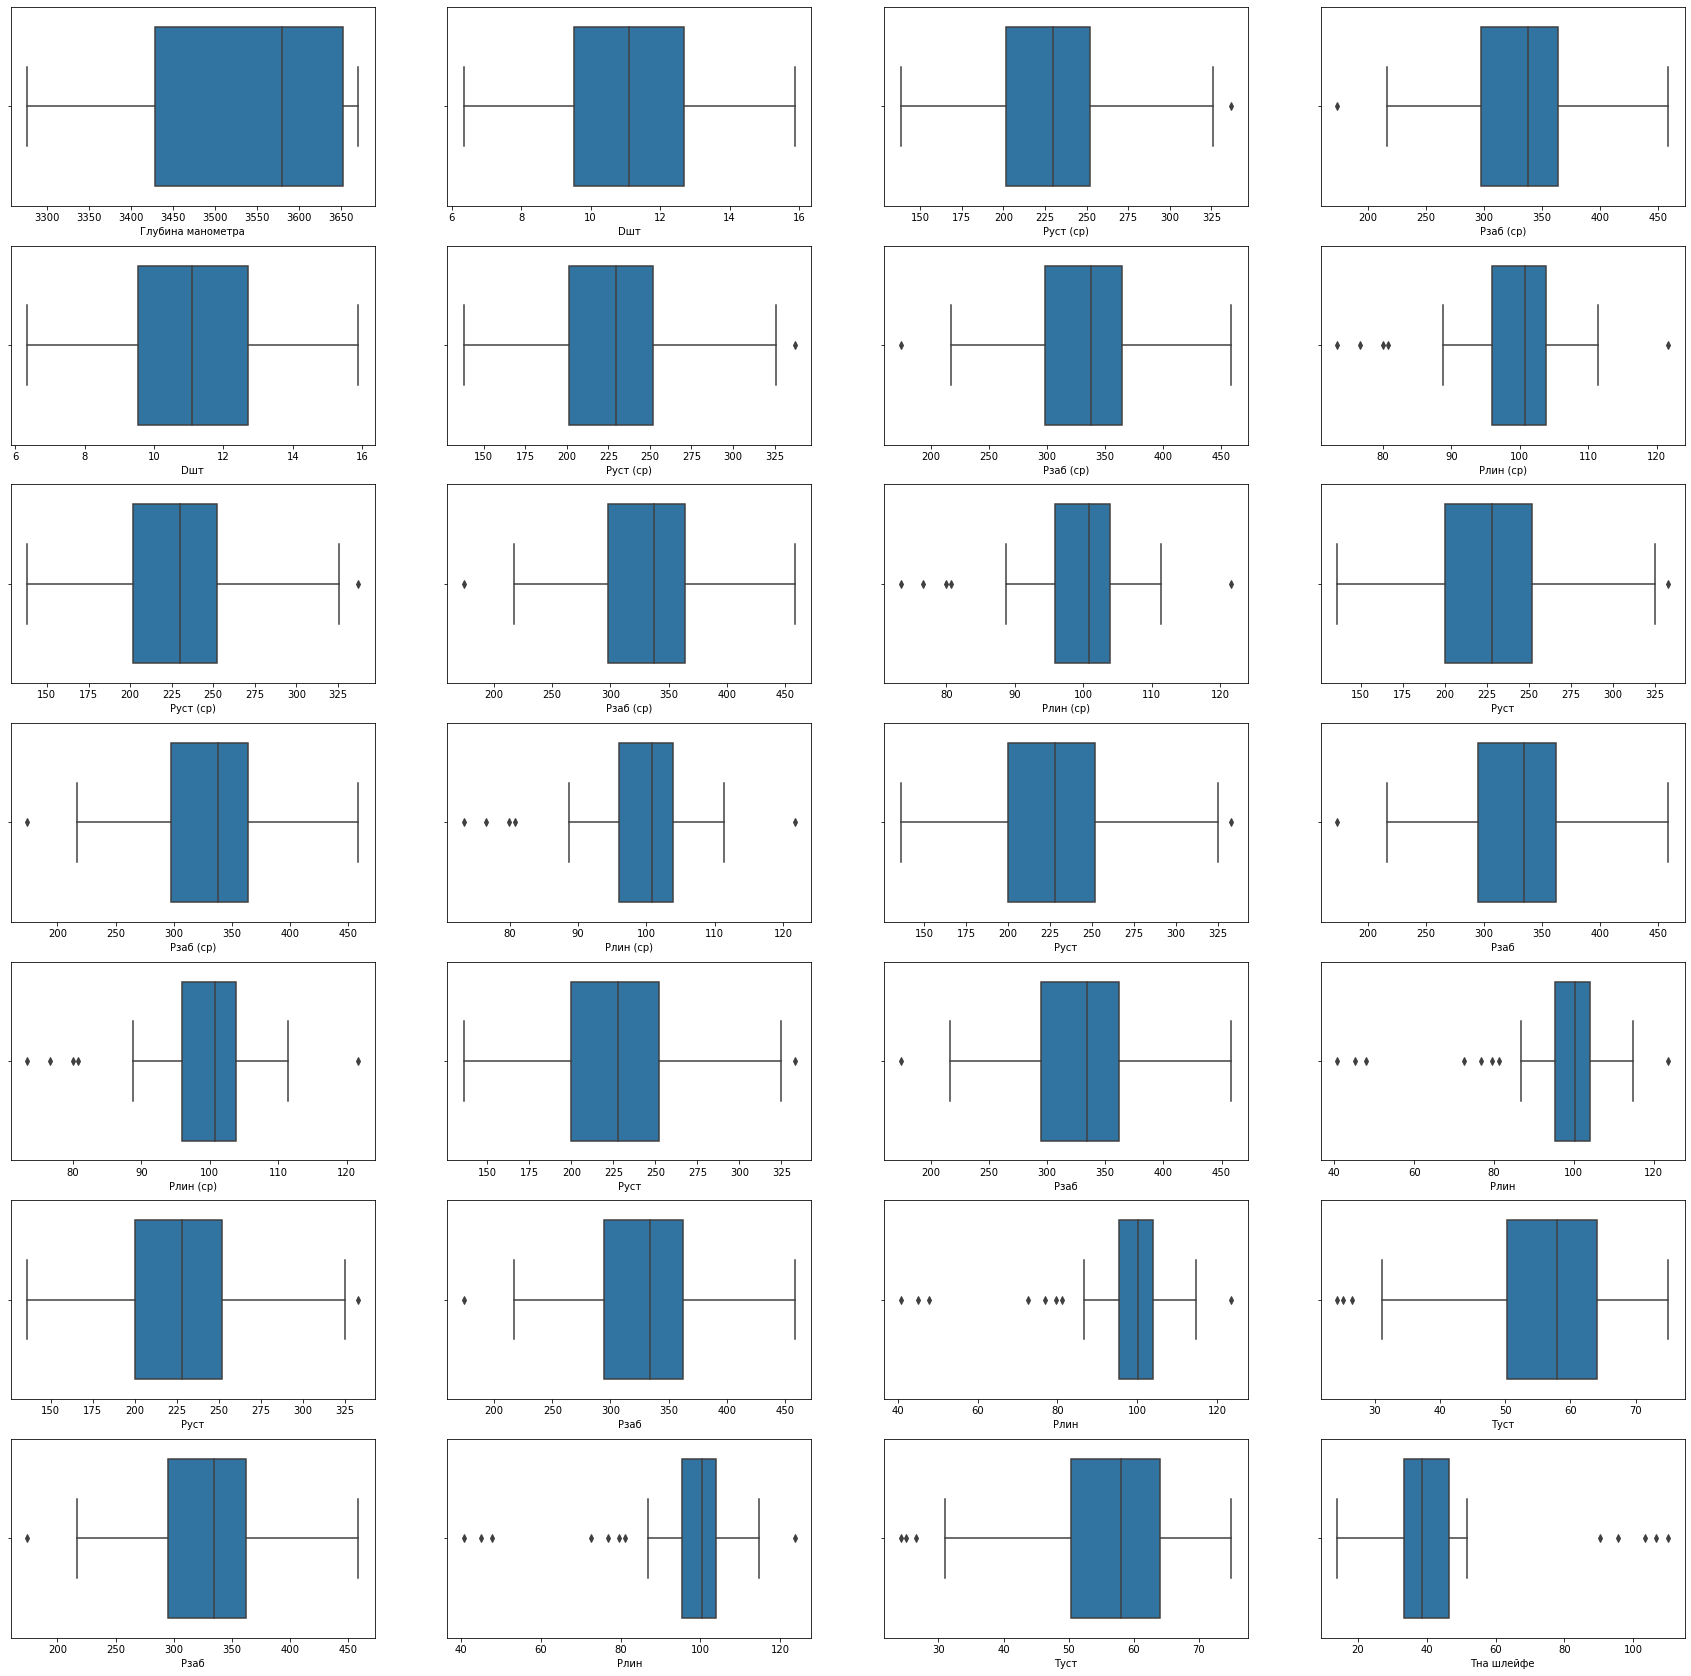

In [177]:
iter_num = 0
col_num = 4
row_num = 7

# figure, axes = plt.subplots(row_num,col_num, figsize=(30, 30))

# for ax in axes:
#     for col, cur_ax in zip(tr.columns[iter_num:col_num+iter_num], ax):
#         print(tr[col])
#         print(cur_ax)
#         sn.boxplot(x=df[col], ax=cur_ax)
#         iter_num += 1

figure, axes = plt.subplots(row_num,col_num, figsize=(30, 30))
for ax in axes:
    for col, cur_ax in zip(df.columns[iter_num:col_num+iter_num], ax):
        sn.boxplot(x=df[col], ax=cur_ax)
    iter_num += 1
